CODE BLOCK: 1

In [1]:
import torch
# Torch is the top level PyTorch package in tensor library. Hence, we are importing it first
import torch.nn as nn
# Importing the base class for all neural network modules
import torch.nn.functional as F
# Importing functional class that contains convolutions and other related functions
import torch.optim as optim
# torch.optim is a package implementing various optimization algorithms
from torchvision import datasets, transforms
# torchvision is a package that provides us access to popular datasets, model architectures & image transformations for computer vision
# torchvision.transforms is an interface to give us access to common tranformations for image processing
!pip install torchsummary
# This is collab way to install packages and here we are installing torchsummary
from torchsummary import summary
# Summary provides us insight into model parameters
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import os

from model import Net
from utils import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


CODE BLOCK: 2

In [2]:
# Moved to utils.py
device=get_device()

cuda


CODE BLOCK: 3

In [3]:
# Moved to utils.py

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms())
# The dataset named "MNIST" is being called from within the torchvision available datasets
# MNIST is a dataset containing handwritten digits
# The training part of the dataset is downloaded to ../data location
# This is also the Extract (E) part of the ETL process where we are going to extract the dataset from raw data
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms())
# The test part of the dataset is downloaded to ../data location

CODE BLOCK: 5

In [5]:
batch_size = 32
# Batch Size is a tunable parameter that tells us how many images can be sent in parallel to the model. 
# This depends on the available memory and can be increased/decreased accordingly. This is tuned after the model is ran and based on available memory
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
# trainloader is sort of "for" loop for us which will allow to look at or load a lot of images (~batch_size) at same time
# torch.utils.data.DataLoader wraps a dataset and provides access to the underlying data
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
# test till help to check accuracy of our model

CODE BLOCK: 6

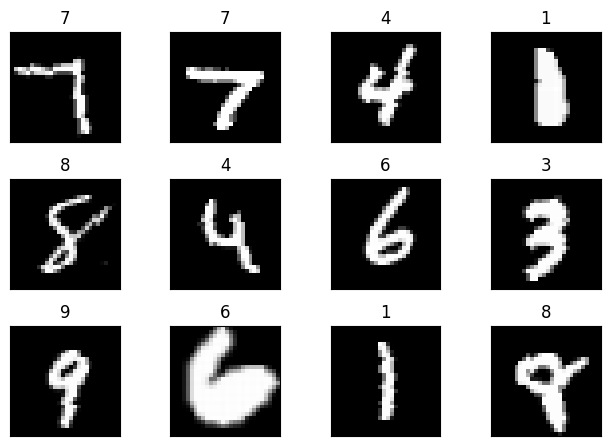

In [6]:
batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [7]:
# Moved to model.py

CODE BLOCK: 8

In [8]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [9]:
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  # here we are using the train component of the model
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # here above we are looping through each batch represented by batch id (like 4th batch, 5th batch, etc) and data is images of batch and target is the label  
    data, target = data.to(device), target.to(device)
    # since model is being trained on GPU, we need to send data and targets also to GPU. They can't be on CPU
    optimizer.zero_grad()
    # When we do back propagation, the gradients will be stored at one place and we need to initiate gradients as zero to begin withwhich is done in this step
    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    # Computing loss using negative likelyhood loss function. Comparision is made between predicted output with targets
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    # The loss is sent to backpropagation and here the gradients are computed based on the loss
    optimizer.step()
    # Applying the gradients to the parameters
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    # here we are involking the evaluation method of the model object
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # Here we are looping through the images and labels in the test dataset
            data, target = data.to(device), target.to(device)
            # since model is being trained on GPU, we need to send data and targets also to GPU. They can't be on CPU
            output = model(data)
            # we are sending model output to output variable
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            # Computing loss using negative likelyhood loss function. Comparision is made between predicted output with targets
            # We are also summing up batch loss
            correct += GetCorrectPredCount(output, target)
            # Summing up the correct predictions

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [ ]:
model = Net().to(device)
# Creating an object of the class we created and sending that object to GPU
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Optimizes using stochastic gradient descent optimization algorithm with learning rate of 0.01 and momentum of 0.9
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0045 Batch_id=1874 Accuracy=93.32: 100%|██████████| 1875/1875 [05:32<00:00,  5.64it/s]


Test set: Average loss: 0.0377, Accuracy: 9866/10000 (98.66%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0028 Batch_id=1874 Accuracy=98.18: 100%|██████████| 1875/1875 [05:24<00:00,  5.78it/s]


Test set: Average loss: 0.0270, Accuracy: 9905/10000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0045 Batch_id=1874 Accuracy=98.58: 100%|██████████| 1875/1875 [05:25<00:00,  5.77it/s]


Test set: Average loss: 0.0187, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0010 Batch_id=1874 Accuracy=98.79: 100%|██████████| 1875/1875 [05:25<00:00,  5.77it/s]


Test set: Average loss: 0.0262, Accuracy: 9919/10000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0167 Batch_id=1874 Accuracy=98.97: 100%|██████████| 1875/1875 [05:25<00:00,  5.76it/s]


Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 6


Train: Loss=0.0003 Batch_id=1874 Accuracy=99.43: 100%|██████████| 1875/1875 [05:30<00:00,  5.68it/s]


Test set: Average loss: 0.0141, Accuracy: 9958/10000 (99.58%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7


Train: Loss=0.0148 Batch_id=1874 Accuracy=99.53: 100%|██████████| 1875/1875 [05:21<00:00,  5.82it/s]


Test set: Average loss: 0.0138, Accuracy: 9957/10000 (99.57%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8


Train: Loss=0.0047 Batch_id=1874 Accuracy=99.55: 100%|██████████| 1875/1875 [05:19<00:00,  5.86it/s]


Test set: Average loss: 0.0143, Accuracy: 9952/10000 (99.52%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9


Train: Loss=0.0018 Batch_id=1874 Accuracy=99.50: 100%|██████████| 1875/1875 [05:17<00:00,  5.91it/s]


Test set: Average loss: 0.0144, Accuracy: 9954/10000 (99.54%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10


Train: Loss=0.0031 Batch_id=1874 Accuracy=99.56: 100%|██████████| 1875/1875 [05:16<00:00,  5.93it/s]


Test set: Average loss: 0.0151, Accuracy: 9950/10000 (99.50%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 11


Train: Loss=0.0068 Batch_id=1874 Accuracy=99.58: 100%|██████████| 1875/1875 [05:15<00:00,  5.93it/s]


Test set: Average loss: 0.0144, Accuracy: 9949/10000 (99.49%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 12


Train: Loss=0.1245 Batch_id=1874 Accuracy=99.62: 100%|██████████| 1875/1875 [05:21<00:00,  5.83it/s]


Test set: Average loss: 0.0142, Accuracy: 9951/10000 (99.51%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13


Train: Loss=0.0525 Batch_id=1874 Accuracy=99.61: 100%|██████████| 1875/1875 [05:24<00:00,  5.78it/s]


Test set: Average loss: 0.0142, Accuracy: 9952/10000 (99.52%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 14


Train: Loss=0.0013 Batch_id=206 Accuracy=99.74:  11%|█         | 207/1875 [00:34<04:13,  6.58it/s]

CODE BLOCK: 11

In [1]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

NameError: ignored

In [ ]:
summary(model, input_size=(1, 28, 28))